<a href="https://colab.research.google.com/github/armiro/Pneumothorax-Segmentation/blob/master/dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 121kB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os, shutil, glob, cv2, pydicom
import pandas as pd
import seaborn as sns

In [ ]:
# first, load the dataset
path = '/content/drive/My Drive/Datasets/siim_acr_pneumothorax_seg/siim_acr_step1/siim'
training_path = path + '/dicom-images-train/*/*/*.dcm'
test_path = path + '/dicom-images-test/_/_/*.dcm'

%time X_train = glob.glob(pathname=training_path)
%time X_test = glob.glob(pathname=test_path)

metadata = pd.read_csv(filepath_or_buffer=path+'/train-rle.csv', index_col=None)
print('metadata header:', metadata.columns)

CPU times: user 4.51 s, sys: 4.63 s, total: 9.14 s
Wall time: 38min 55s
CPU times: user 8.67 ms, sys: 1.62 ms, total: 10.3 ms
Wall time: 44.1 ms
metadata header: Index([' EncodedPixels'], dtype='object')


storage info:
study ID: 1.2.276.0.7230010.3.1.2.8323329.6031.1517875194.107593
series ID: 1.2.276.0.7230010.3.1.3.8323329.6031.1517875194.107592
image ID: 1.2.276.0.7230010.3.1.4.8323329.6031.1517875194.107594
storage type: 1.2.840.10008.5.1.4.1.1.7

patient info:
ID: 1db903d7-7884-4414-993e-728558f72349 / sex: F / age: 37

x-ray info:
modality: CR / body-part: CHEST / view: PA

image info:
image size: 1024 * 1024
image pixel spacing: [0.14300000000000002, 0.14300000000000002]



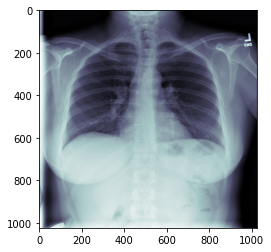

In [ ]:
# print dicom metadata and plot image pixels for a random image
def show_dcm_info(image):
    print('storage info:')
    print('study ID:', image.StudyInstanceUID)
    print('series ID:', image.SeriesInstanceUID)
    print('image ID:', image.SOPInstanceUID)
    print('storage type:', image.SOPClassUID)
    print()
    print('patient info:')
    print('ID:', image.PatientID, '/ sex:', image.PatientSex, '/ age:', image.PatientAge)
    print()
    print('x-ray info:')
    print('modality:', image.Modality, '/ body-part:', image.BodyPartExamined,
          '/ view:', image.ViewPosition)
    print()
    print('image info:')
    if 'PixelData' in image:
        rows = int(image.Rows)
        columns = int(image.Columns)
        print('image size: %d * %d' %(rows, columns))
    if 'PixelSpacing' in image:
        print('image pixel spacing:', image.PixelSpacing)
    print()
    

def plot_dcm_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(X=image.pixel_array, cmap='bone')
    plt.show()



test_img = pydicom.dcmread(X_train[np.random.randint(0, len(X_train))])
show_dcm_info(image=test_img)
plot_dcm_image(image=test_img)


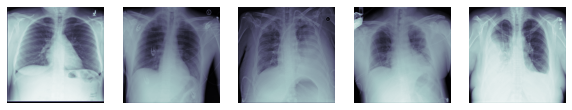

In [ ]:
# let's see some snaps from the dataset
num_snaps = 5
indices = np.random.randint(low=0, high=len(X_train), size=num_snaps)

fig = plt.figure(figsize=(10, 50))
for i in range(1, num_snaps+1):
    plt.subplot(1, num_snaps, i)
    this_img = pydicom.read_file(fp=X_train[indices[i-1]])
    plt.imshow(X=this_img.pixel_array, cmap='bone')
    plt.axis('off')
plt.show()
# fig.savefig(fname='dataset_snaps.png', bbox_inches='tight')

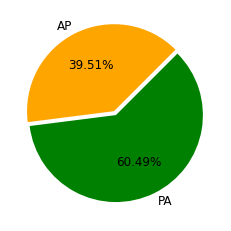

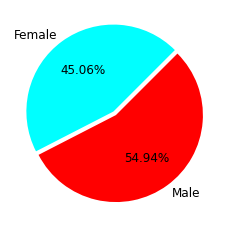

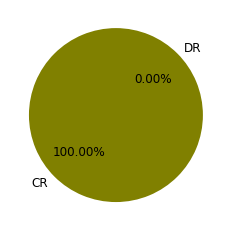

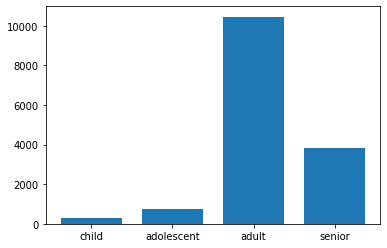

In [ ]:
# plot the distribution of each metadata feature in the dataset
projections = [0, 0]
patient_sex = [0, 0]
modality = [0, 0]
patient_age = [0, 0, 0, 0]
for img_path in X_train+X_test:
    this_img = pydicom.read_file(fp=img_path, stop_before_pixels=True)
    # projection
    if this_img.ViewPosition == 'AP':
        projections[0] += 1
    elif this_img.ViewPosition == 'PA':
        projections[1] += 1
    else:
        print('unknown projection')
    # patient sex
    if this_img.PatientSex == 'F':
        patient_sex[0] += 1
    elif this_img.PatientSex == 'M':
        patient_sex[1] += 1
    else:
        print('unknown patient sex')
    # modality
    if this_img.Modality == 'CR':
        modality[0] += 1
    elif this_img.Modality == 'DR':
        modality[1] += 1
    else:
        print('unknown modality')
    # patient age (boundaries: https://www.cdc.gov/nchs/products/databriefs/db334.htm)
    if int(this_img.PatientAge) <= 11:
        patient_age[0] += 1
    elif 12 <= int(this_img.PatientAge) <= 19:
        patient_age[1] += 1
    elif 20 <= int(this_img.PatientAge) <= 59:
        patient_age[2] += 1
    elif 60 <= int(this_img.PatientAge):
        patient_age[3] += 1
    else:
        print('unknown patient age')
    
    # if int(this_img.Rows) != 1024:
    #     print(this_img.Rows, this_img.Columns) 


fig = plt.figure()
plt.pie(x=projections, explode=(0.05, 0.0), labels=['AP', 'PA'], colors=['orange', 'green'],
        autopct='%1.2f%%', startangle=45, textprops={'fontsize': 12.0})
plt.show()
fig.savefig(fname='/content/drive/My Drive/projections.png', bbox_inches='tight')

fig = plt.figure()
plt.pie(x=patient_sex, explode=(0.05, 0.0), labels=['Female', 'Male'], colors=['cyan', 'red'],
        autopct='%1.2f%%', startangle=45, textprops={'fontsize': 12.0})
plt.show()
fig.savefig(fname='/content/drive/My Drive/patient_sex.png', bbox_inches='tight')

fig = plt.figure()
plt.pie(x=modality, labels=['CR', 'DR'], colors=['olive', 'purple'],
        autopct='%1.2f%%', startangle=45, textprops={'fontsize': 12.0})
plt.show()
fig.savefig(fname='/content/drive/My Drive/modality.png', bbox_inches='tight')

fig = plt.figure()
plt.bar(x=['child', 'adolescent', 'adult', 'senior'], height=patient_age, width=0.75)
plt.show()
fig.savefig(fname='/content/drive/My Drive/patient_age.png', bbox_inches='tight')

In [ ]:
print('num training images:', len(X_train))
print('num test images:', len(X_test))
# print(projections, modality, patient_sex, patient_age)

num training images: 12089
num test images: 3205


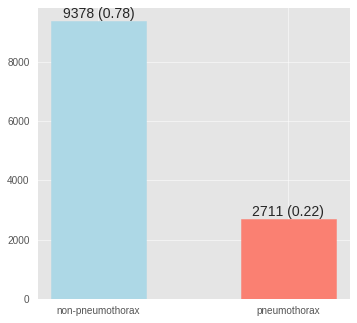

In [ ]:
# plot the distribution of each class
labels = metadata.loc[:, ' EncodedPixels']
num_neg_samples = 0
for label in labels:
    if label == '-1':
        num_neg_samples += 1
num_pos_samples = len(X_train) - num_neg_samples

fig = plt.figure(figsize=(5, 5))
plt.style.use(style='ggplot')
bar_list = plt.bar(x=['non-pneumothorax', 'pneumothorax'], height=[num_neg_samples, num_pos_samples], width=0.5)
bar_list[0].set_color('lightblue'), bar_list[1].set_color('salmon')
plt.text(x=0 , y=num_neg_samples+1 , s='%d (%.2f)' % (num_neg_samples, num_neg_samples/len(X_train)) , 
         fontdict=dict(fontsize=14), ha='center', va='bottom')
plt.text(x=1 , y=num_pos_samples+1 , s='%d (%.2f)' % (num_pos_samples, num_pos_samples/len(X_train)) , 
         fontdict=dict(fontsize=14), ha='center', va='bottom')
plt.show()
# fig.savefig(fname='/content/drive/My Drive/class_distribution.png', bbox_inches='tight')

In [ ]:
# how many images have multiple masks?
num_masks = metadata['ImageId'].value_counts()
num_multimasks = 0
temp = 0
for val in num_masks:
    if val > 1:
        num_multimasks += 1
        temp += val

num_unimasks = num_pos_samples - num_multimasks

print('multiple masks: %d images have %d masks' % (num_multimasks, temp))
print('single mask: %d images have one mask' % num_unimasks)

multiple masks: 624 images have 1531 masks
single mask: 2087 images have one mask


In [277]:
# function to extract mask from rle-coded data
def rle2mask(rle, width, height):
    mask = np.zeros(width*height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for idx, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[idx]] = 255
        current_position += lengths[idx]
    
    return np.rot90(np.flip(m=mask.reshape(width, height), axis=1))

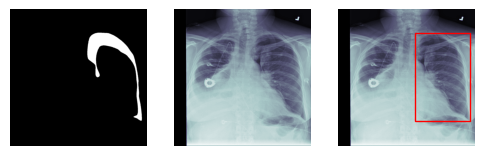

In [280]:
# let's see some masks and draw their boundaries over image
test_rle = metadata.values[4][-1]
test_mask = rle2mask(rle=test_rle, width=1024, height=1024)
plt.style.use(style='default')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 18))
ax1.imshow(test_mask, cmap='gray')
ax1.axis('off')


test_img_name = metadata.values[4][0]
for pth in glob.glob(pathname=training_path):
    if pth.find(test_img_name) != -1:
        test_img_path = pth
        break
test_img = pydicom.dcmread(fp=test_img_path)
ax2.imshow(test_img.pixel_array, cmap='bone')
ax2.axis('off')


i, j = np.where(test_mask)
mask_rect = patches.Rectangle(xy=(min(j), min(i)), width=max(j)-min(j), height=max(i)-min(i), linewidth=1.0, edgecolor='red', facecolor='none')
ax3.imshow(test_img.pixel_array, cmap='bone')
ax3.axis('off')
ax3.add_patch(mask_rect)

plt.show()
fig.savefig(fname='/content/drive/My Drive/test_masked_img2.png', bbox_inches='tight')